In [1]:
import base64
import os
from datetime import datetime, timezone
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import csv
import schedule
import time
import blake3

# Dictionary to store keys with timestamps
key_storage = {}
# Maximum number of keys to keep in memory (changed to 1)
MAX_KEYS = 1

# Function to generate a dynamic key based on the current minute
def generate_key():
    """Generate a dynamic key based on the current time."""
    current_time = datetime.now(timezone.utc)  # Get current time in UTC
    time_str = current_time.strftime("%Y%m%d%H%M")  # Get year, month, day, hour, and minute as a string
    key = base64.urlsafe_b64encode(time_str.encode('utf-8')).ljust(32, b'\0')
    key_bytes = key[:32]
    
    # Store the key with timestamp
    timestamp = current_time.timestamp()
    key_storage[timestamp] = key_bytes
    
    # Clean up old keys if we exceed our limit
    cleanup_old_keys()
    
    return key_bytes

# Function to clean up old keys
def cleanup_old_keys():
    """Delete old keys when we exceed the maximum number of keys to store."""
    if len(key_storage) > MAX_KEYS:
        # Sort timestamps and remove the oldest ones
        timestamps = sorted(key_storage.keys())
        keys_to_remove = timestamps[:-MAX_KEYS]  # Keep only the MAX_KEYS most recent
        
        for ts in keys_to_remove:
            print(f"Removing old key from {datetime.fromtimestamp(ts, timezone.utc)}")
            del key_storage[ts]

# Function to hash the key using blake3
def hash_key(key):
    """Hash the key using blake3."""
    return blake3.blake3(key).digest()

# Function to encrypt data using AES
def encrypt(data, key):
    """Encrypt data using the provided key."""
    iv = os.urandom(16)
    
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data) + padder.finalize()
    
    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
    return iv + encrypted_data

# Function to encrypt a CSV file
def encrypt_csv(input_csv, encrypted_csv):
    """Encrypt a CSV file."""
    with open(input_csv, 'r') as infile:
        reader = csv.reader(infile)
        rows = list(reader)

    # Convert CSV rows to bytes for encryption
    data = "\n".join([",".join(row) for row in rows]).encode('utf-8')

    # Generate key based on current time
    key = generate_key()
    print(f"Generated Key (before hashing): {key}")
    print(f"Number of keys in memory: {len(key_storage)}")

    # Hash the key using blake3
    hashed_key = hash_key(key)
    print(f"Hashed Key: {hashed_key}")

    # Encrypt the data
    encrypted_data = encrypt(data, hashed_key)

    # Save the encrypted data to a file
    with open(encrypted_csv, 'wb') as outfile:
        outfile.write(encrypted_data)
    
    print(f"Encrypted CSV saved to {encrypted_csv}")

# Function to run the encryption process every minute
def scheduled_task():
    input_csv = "/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/normal-traffic.csv"  # Replace with your CSV file path
    encrypted_csv = "/Users/bodapati/Documents/encrypted_data.csv"  
    encrypt_csv(input_csv, encrypted_csv)

# Schedule the task to run every minute
schedule.every(1).minutes.do(scheduled_task)

# Run the scheduler
if __name__ == "__main__":
    print("Starting the scheduler...")
    scheduled_task()  
    while True:
        schedule.run_pending()
        time.sleep(1)

Starting the scheduler...
Generated Key (before hashing): b'MjAyNTA0MDYxMjMz\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
Number of keys in memory: 1
Hashed Key: b'\x16@\xa8\xe5$\xe74d}0I\xff\xb1]< ?\xad7\xab\xca\xd8\x97\\\xed\xea\x85\xcc\xdc\x9e:O'
Encrypted CSV saved to /Users/bodapati/Documents/encrypted_data.csv


KeyboardInterrupt: 

/var/folders/tx/k8p2xbtn0cjgvn8dh714226r0000gn/T/ipykernel_68787/824684388.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


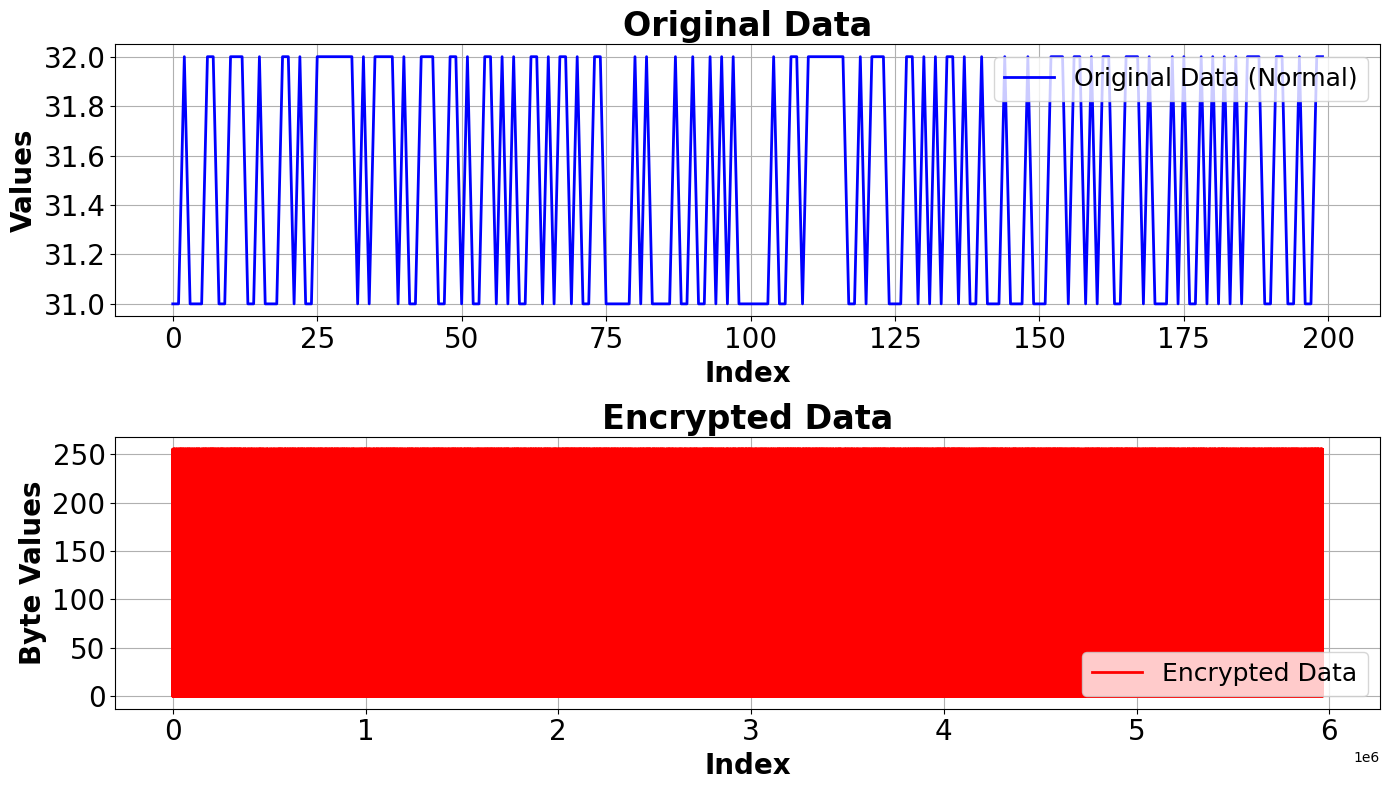

In [4]:
import base64
import os
from datetime import datetime, timezone
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import csv
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a dynamic key based on the current minute
def generate_key():
    current_time = datetime.now(timezone.utc)
    time_str = current_time.strftime("%Y%m%d%H%M")
    key = base64.urlsafe_b64encode(time_str.encode('utf-8')).ljust(32, b'\0')
    return key[:32]

# Function to encrypt data using AES
def encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data) + padder.finalize()
    
    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
    return iv + encrypted_data

# Function to read CSV file and return raw data
def read_csv(file_path):
    with open(file_path, 'r') as infile:
        reader = csv.reader(infile)
        rows = [row for row in reader]
    return rows

# Paths to the files
original_csv = "/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/normal-traffic.csv"
encrypted_csv = "/Users/bodapati/Documents/encrypted_data.csv"

# Read the original data
original_data = read_csv(original_csv)
original_flat = [float(cell) for row in original_data for cell in row if cell.replace('.', '', 1).isdigit()]

# Read the encrypted data as raw bytes
with open(encrypted_csv, 'rb') as enc_file:
    encrypted_data = enc_file.read()

# Convert encrypted bytes into numeric values for plotting
encrypted_numeric = [b for b in encrypted_data]

# Plotting the comparison
plt.figure(figsize=(14, 8))  # Larger figure

# Plot original data
plt.subplot(2, 1, 1)
plt.plot(range(len(original_flat)), original_flat, label="Original Data (Normal)", color='blue', linewidth=2)
plt.title("Original Data", fontsize=24, fontweight='bold')
plt.xlabel("Index", fontsize=20, fontweight='bold')
plt.ylabel("Values", fontsize=20, fontweight='bold')
plt.grid(True)
plt.legend(fontsize=18)

# Increase font size of numbers on the axes
plt.xticks(fontsize=20)  # Larger font for x-axis numbers
plt.yticks(fontsize=20)  # Larger font for y-axis numbers

# Plot encrypted data
plt.subplot(2, 1, 2)
plt.plot(range(len(encrypted_numeric)), encrypted_numeric, label="Encrypted Data", color='red', linewidth=2)
plt.title("Encrypted Data", fontsize=24, fontweight='bold')
plt.xlabel("Index", fontsize=20, fontweight='bold')
plt.ylabel("Byte Values", fontsize=20, fontweight='bold')
plt.grid(True)
plt.legend(fontsize=18)

# Increase font size of numbers on the axes
plt.xticks(fontsize=20)  # Larger font for x-axis numbers
plt.yticks(fontsize=20)  # Larger font for y-axis numbers

# Display the plots
plt.tight_layout()
plt.show()
